In [1]:
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Data Augmentation

In [2]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
        # transforms.Lambda(to_uint8),
    # to_uint8, # 가능
    # transforms.Lambda(lambda x:(255*x).type(torch.uint8)),
    # lambda x:(255*x).type(torch.uint8), # 가능
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    # (아마도) 이미지넷 데이터 전체 픽셀에 대해서 구한 평균, std 값
    
    # transforms.Resize(size=(20,20)), # size는 (height,width)
    # transforms.CenterCrop(size=(20,20)), # size 는 (height, width)
    # transforms.Pad(6), # 20+6*2 = 32
    # transforms.RandomApply(nn.ModuleList([transforms.CenterCrop(size=(20,20)),
    #                                       transforms.Pad(6)]), p=0.5), # ModuleList 안해도 되더라
    # transforms.RandomCrop(size=(20,20)), # 어디를 자를지 random 하게 자름
    # transforms.RandomResizedCrop(size=(20,20), scale=(0.3,1), ratio=(0.3,1.7)),
    # random 하게 자른 다음에 resize라서 RandomCrop과 다름
    # scale은 어느 정도로 작은 범위를 자를지 (0~1 사이 값)
    # ratio는 aspect ratio로, 가로 길이/세로 길이 를 의미한다.
    # (a,b) <- a 와 b 사이 값을 uniform random 하게 뽑아요

    # transforms.RandomGrayscale(p=0.5), # gray로 바꾸는 데, 출력 채널 수를 3으로 유지
    # transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.5, hue=0.15), 
    # 밝기, 대비, 채도, 색조가 센서마다 다를 수 있음을 고려 (number: percentage to convert)
    # 밝기(brightness)를 키우면 밝은 부분에서 saturation이 일어나면서, HDR이 낮은 센서에 대응 가능
    # 대비(contrast) augmentation은 HDR이 서로 다른 센서에 대응 가능
    # 채도(saturation) 및 색조(hue) augmentation은 ISP에서 color correction matrix 값이 센서마다 서로 다른 경우 등,
    # 색 표현이 다른 센서에 대응 가능
    # transforms.RandomAutocontrast(p=0.5), # p의 확률로 대비를 자동 조정
    # transforms.RandomEqualize(p=0.5), # p의 확률로 R,G,B histogram을 일치시킴 (이건 uint8로 되어있는 이미지만 가능)
    # transforms.RandomInvert(p=0.5), # p의 확률로 색반전
    # new 픽셀 값 = 최댓 값 - 기존의 픽셀 값 을 통해 반전시킴
    # transforms.RandomSolarize(threshold=200, p=0.5), 
    # p의 확률로(즉 그 이미지에 대해 할지 말지 정하고) threshold 넘는 픽셀 값에 대해 inverting
    # transforms.RandomPosterize(bits=3, p=0.5),
    # 픽셀 하나가 가지는 값의 bit수(0~8)를 p의 확률로 bits로 바꿈 (이건 uint8로 되어있는 것만 가능)

    # transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1,2)),
    # kernel_size = (가로,세로) sigma=(min,max) min ~ max 에서 uniform 하게 하나 뽑음
    # transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    # sharpness_factor = 1 이면 원래 이미지, 0에 가까우면 blur, 1보다 클수록 sharp해짐

    # transforms.RandomHorizontalFlip(p=0.4), # p 확률로 좌우반전
    # transforms.RandomVerticalFlip(p=0.5), # p 확률로 상하반전
    # transforms.RandomRotation(degrees=(0,180)), # 0~180도 랜덤하게 회전
    # transforms.RandomAffine(degrees=(0,30),translate=(0.1,0.3),scale=(0.5,1.2)),
    # translate는 이동하는 정도 (비율), scale은 크기 조절
    # transforms.RandomPerspective(distortion_scale=0.6, p=0.5), # distortion 정도 0~1 사이, default는 0.5, p는 적용 확률
    
    # transforms.RandomErasing(p=0.5, scale=(0.03,0.3), ratio=(0.3,3.3)),
    # scale: 이미지의 몇 퍼 정도를 지울지
    # ratio: 지우는 영역의 aspect ratio

    # transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    # transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    # transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN),
    # AutoAugment:Learning Augmentation Strategies from Data 라는 논문에 따른 augmentation (uint8 이여야 함)
    # transforms.RandAugment(),
    # RandAugment: Practical automated data augmentation with a reduced search space 라는 논문에 따른 augmentation (uint8 이여야 함)
    # transforms.TrivialAugmentWide(),
    # TrivialAugment: Tuning-free Yet State-of-the-Art Data Augmentation 라는 논문에 따른 augmentation (uint8)
    # transforms.AugMix(),
    # AugMix: A Simple Data Processing Method to Improve Robustness and Uncertainty 라는 논문에 따른 augmentaiton (uint8)
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

### STL10 datset
- 'train': 레이블이 지정된 학습 데이터만 로드합니다.
- 'test': 테스트 데이터만 로드합니다.
- 'unlabeled': 레이블이 지정되지 않은 데이터만 로드합니다.
- 'train+unlabeled': 학습 데이터와 레이블이 지정되지 않은 데이터를 함께 로드합니다.

In [3]:
train_DT = datasets.STL10(root='dataset', split='train', download=True)
test_DT = datasets.STL10(root='dataset', split='test', download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class CustomDataset(Dataset):
    def __init__(self, STL10_Dataset):
        self.data = torch.tensor(STL10_Dataset.data) / 255.0
        self.label = torch.tensor(STL10_Dataset.labels)
    
    def __len__(self):
        return len(self.label)

    def __getitem__(self, index):
        return self.data[index], self.label[index]

train_dataset, val_dataset = random_split(dataset=CustomDataset(train_DT), lengths=(4000, 1000))
test_dataset = CustomDataset(test_DT)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True, drop_last=True)

<class 'torch.Tensor'>
Label : 3
Label name : cat


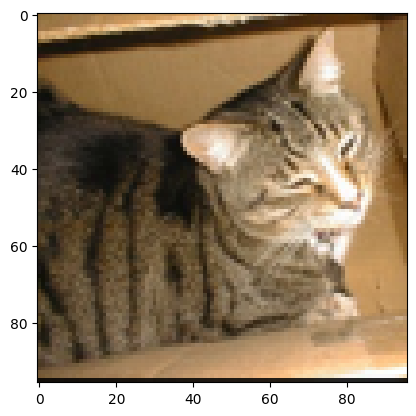

In [5]:
for x, y in train_dataloader:
    print(type(x))
    plt.imshow(x[0].permute(1, 2, 0))
    print('Label :', int(y[0]))
    print('Label name :', train_DT.classes[int(y[0])])
    break

In [6]:
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.MaxPool1 = nn.MaxPool2d(2, 2)

        self.conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.MaxPool2 = nn.MaxPool2d(2, 2)

        self.conv3 =  nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.MaxPool3 = nn.MaxPool2d(2, 2)

        self.conv4 =  nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.MaxPool4 = nn.MaxPool2d(2, 2)

        self.fc = nn.Sequential(
            nn.Linear(18432, 64),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.MaxPool1(self.conv1(x))
        x = self.MaxPool2(self.conv2(x))
        x = self.MaxPool3(self.conv3(x))
        x = self.MaxPool4(self.conv4(x))
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

model = CustomModel()
x = torch.randn(64, 3, 96, 96)
print(model(x).shape)

torch.Size([64, 10])


In [7]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

model = CustomModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.00002)
# lr 스케쥴러 할당
lr_scheduler = StepLR(optimizer=optimizer, step_size=10, gamma=0.9)

train_loss_history = []
val_loss_history = []
best_val_loss = 9999.0

for epoch in range(30):
    model.train()
    train_loss = 0.0
    
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        pred_y = model(x)
        loss = criterion(pred_y, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss
    
    lr_scheduler.step()
    train_loss = train_loss / len(train_dataloader)
    train_loss_history.append(train_loss.detach().cpu())

    # val_dataset으로 평가
    with torch.no_grad():
        model.eval()
        val_loss = 0.0

        for x, y in val_dataloader:
            x = x.to(device)
            y = y.to(device)

            pred_y = model(x)
            loss = criterion(pred_y, y)
        
            val_loss += loss

            # 제일 validation_loss가 적을때의 state 저장
            if float(val_loss) < best_val_loss:
                best_val_loss = float(val_loss)

                torch.save(
                    {
                        'model' : model,
                        'epoch' : epoch,
                        'optimizer' : optimizer
                    },
                    './model/CIFAR10_val.pt'
                )
        
        val_loss = val_loss / len(val_dataloader)
        val_loss_history.append(val_loss.detach().cpu())

        # training의 HyperParameter 저장
        torch.save(
            {
                'epoch':epoch,
                'batch_size':64,
            },
            'model/CIFAR10_hyperparameters.py'
        )
        
    print(f'Epoch:{epoch+1:2}    Train_Loss : {round(float(train_loss), 3):5}    Val_Loss : {round(float(val_loss), 3):5}    Curr_LR:{optimizer.param_groups[0]['lr']}')

Epoch: 1    Train_Loss : 1.857    Val_Loss : 1.654    Curr_LR:2e-05
Epoch: 2    Train_Loss : 1.451    Val_Loss : 1.422    Curr_LR:2e-05
Epoch: 3    Train_Loss : 1.257    Val_Loss : 1.354    Curr_LR:2e-05
Epoch: 4    Train_Loss :  1.12    Val_Loss : 1.279    Curr_LR:2e-05
Epoch: 5    Train_Loss : 0.993    Val_Loss : 1.229    Curr_LR:2e-05
Epoch: 6    Train_Loss : 0.897    Val_Loss : 1.183    Curr_LR:2e-05
Epoch: 7    Train_Loss : 0.811    Val_Loss :  1.13    Curr_LR:2e-05
Epoch: 8    Train_Loss : 0.719    Val_Loss :  1.11    Curr_LR:2e-05
Epoch: 9    Train_Loss : 0.656    Val_Loss : 1.089    Curr_LR:2e-05
Epoch:10    Train_Loss : 0.582    Val_Loss : 1.094    Curr_LR:1.8e-05
Epoch:11    Train_Loss : 0.524    Val_Loss : 1.062    Curr_LR:1.8e-05
Epoch:12    Train_Loss : 0.481    Val_Loss : 1.057    Curr_LR:1.8e-05
Epoch:13    Train_Loss : 0.429    Val_Loss : 1.022    Curr_LR:1.8e-05
Epoch:14    Train_Loss :  0.39    Val_Loss : 1.005    Curr_LR:1.8e-05
Epoch:15    Train_Loss : 0.353    Val_

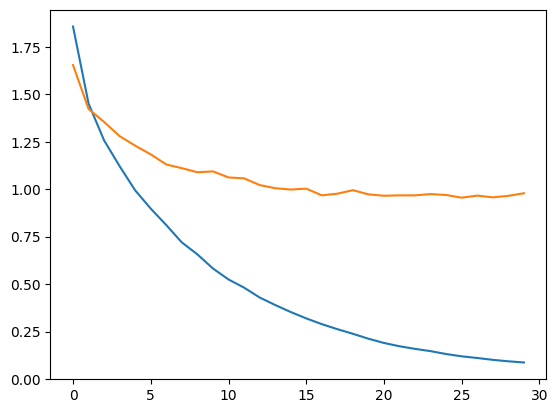

In [8]:
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.show()

In [9]:
correct = 0
wrong = 0

with torch.no_grad():
    model.eval()

    for x, y in test_dataloader:
        x = x.to(device)
        y = y.to(device)

        pred_y = model(x)
        pred_label = torch.argmax(pred_y, dim=1)

        for idx in range(len(y)):
            if y[idx] == pred_label[idx]:
                correct += 1
            else:
                wrong += 1

print(f'Correct  : {correct}')
print(f'Wrong    : {wrong}')
print(f'Accuracy : {round((correct)/(correct+wrong)*100, 2)}%')

Correct  : 5311
Wrong    : 2689
Accuracy : 66.39%
